# Exploring Seattle Airbnb's
- What are the neighborhoods with the best prices?
- What type of property has the best prices ?
- What to expect in terms of cleaning fee and how much it increases the price? 

## Dataset
- Seattle AirBnB and many others datasets available at this link: http://insideairbnb.com/get-the-data.html
- For this notebook, it was used the seattle dataset '17 January, 2019'.

In [64]:
import pandas as pd
import seaborn as sns
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.gridspec as gridspec


%matplotlib inline

pd.set_option('display.max_columns', 106)


calendar = pd.read_csv("./seattle/calendar.csv")
listings = pd.read_csv("./seattle/listings.csv")

c:\users\paulobueno\pycharmprojects\udacity_geral\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (61,62,94) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Functions Used Through the Analysis:

In [65]:
def fix_price(item):
    ''' 
    The function will remove the "$" symbol from the given item and convert to float type. However if 'item' is NaN it will return np.nan
    '''
    x = item
    if(isinstance(x, str)):
        if "$" in x:
            x = x.replace("$", '')
            x = x.replace(",", '')
            x = float(x)
        
    return x


def mean_median_grouped_price(dataframe, column_name, outlier=False):
    """
    Takes dataframe and column 
    return: mean and median groupped by the column name given.
    
    optional: turn 'outlier' param True to filter outliers in dataframe
    """
    
    price_std = dataframe['price'].std()
    
    if outlier:
        #Filtering Price Outliers
        filt = dataframe['price'] <= (dataframe['price'] + (price_std * 3))
        dataframe = dataframe.loc[filt]
        filt = dataframe['price'] >= (dataframe['price'] - (price_std * 3))
        dataframe = dataframe.loc[filt]
    
    # Getting the mean price for each neighbourhood: Price and cleaning fee
    neighbourhood_mean = pd.DataFrame()
    neighbourhood_mean['mean_price'] = dataframe.groupby(listings_neighbourhood[column_name])['price'].mean()
    neighbourhood_mean['mean_fee'] = dataframe.groupby(listings_neighbourhood[column_name])['cleaning_fee'].mean()

    # Getting the median price for each neighbourhood: Normal price and price with cleaning fee
    neighbourhood_median = pd.DataFrame()
    neighbourhood_median['median_price'] = dataframe.groupby(listings_neighbourhood[column_name])['price'].median()
    neighbourhood_median['median_fee'] = dataframe.groupby(listings_neighbourhood[column_name])['cleaning_fee'].median()
    
    return neighbourhood_mean.sort_values(by = 'mean_price'), neighbourhood_median.sort_values(by = 'median_price')


def plot_head_tail_prices(mean_or_median, m_type, column_name):
    
    # Plotting Highest and Lowest Prices with metric type chosen
    fig = plt.figure(constrained_layout=True)
    
    
    if m_type == 'mean':
        if column_name.split('_')[1] != 'cleansed':
            plot_title1 = f"Highest 5 Price Means - {column_name.replace('_',' ').title()}"
            plot_title2 = f"Lowerest 5 Price Means - {column_name.replace('_',' ').title()}"
        else:
            plot_title1 = f"Highest 5 Price Means - {column_name.split('_')[0].title()}"
            plot_title2 = f"Lowerest 5 Price Means - {column_name.split('_')[0].title()}"
        
    elif m_type == 'median':
        plot_title1 = f"Highest 5 Price Medians - {column_name.replace('_',' ').title()}"
        plot_title2 = f"Lowest 5 Price Medians - {column_name.replace('_',' ').title()}"
        

    spec2 = gridspec.GridSpec(ncols=1, nrows=2, figure=fig)
    
    # Setting ax1
    ax1 = fig.add_subplot(spec2[0, 0])
    mean_or_median.tail(5).sort_values(by='mean_price', ascending=False).plot(kind = 'bar',figsize = (10,10), title=plot_title1, ax=ax1, cmap='autumn', alpha=0.5 , rot=0)
    ax1.legend(['Price($)', 'Cleaning Fee ($)'],loc='lower right')
    ax1.title.set_size(20)

    for p in ax1.patches:
        ax1.annotate(f"{p.get_height():.2f}", (p.get_x() * 1.005, p.get_height() * 1.005))
         
    # Setting ax2
    ax2 = fig.add_subplot(spec2[1, 0])
    mean_or_median.head(5).plot(kind = 'bar',figsize = (10,10), title=plot_title2, ax=ax2, cmap='winter', alpha=0.5 , rot=0)
    ax2.legend(['Price($)', 'Cleaning Fee ($)'],loc='lower right')
    ax2.title.set_size(20)

    for p in ax2.patches:
        ax2.annotate(f"{p.get_height():.2f}", (p.get_x() * 1.005, p.get_height() * 1.005))
        
        

## Exploring Listing Dataset

In [66]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2318,https://www.airbnb.com/rooms/2318,20190117134415,2019-01-17,"Casa Madrona - Urban Oasis, 1 block from the P...","Gorgeous, architect remodeled, 1917 Dutch Colo...","Casa Madrona is a gorgeous, architect remodele...","Gorgeous, architect remodeled, (Phone number h...",none,Madrona is a hidden gem of a neighborhood. It ...,"We adhere to a 10pm -9am quiet hour schedule, ...",NaN,Guests can access any part of the house.,We are a family who live next door and are ava...,four day minimum stay,NaN,NaN,https://a0.muscache.com/im/pictures/ac08892c-f...,NaN,2536,https://www.airbnb.com/users/show/2536,Megan,2008-08-26,"Seattle, Washington, United States",I welcome guests from all walks of life and ev...,within an hour,100%,NaN,t,https://a0.muscache.com/im/pictures/user/55737...,https://a0.muscache.com/im/pictures/user/55737...,Minor,3,3,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Seattle, WA, United States",Madrona,Madrona,Central Area,Seattle,WA,98122.0,Seattle,"Seattle, WA",US,United States,47.610819,-122.290816,t,House,Entire home/apt,8,2.5,4,4.0,Real Bed,"{Internet,Wifi,Kitchen,""Free parking on premis...",NaN,$296.00,NaN,NaN,$500.00,$200.00,8,$25.00,4,300,4,4,300,300,4.0,300.0,today,t,28,58,83,358,2019-01-17,21,10,2008-09-15,2018-11-24,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,{WASHINGTON},t,f,strict_14_with_grace_period,f,f,3,2,1,0,0.17
1,3335,https://www.airbnb.com/rooms/3335,20190117134415,2019-01-17,Sweet Seattle Urban Homestead 2 Bdr,Welcome! If you stay here you will be living i...,Welcome! Come enjoy your time in Seattle at a...,Welcome! If you stay here you will be living i...,none,This is a very diverse neighborhood with a var...,We are an urban farmy oasis and invite you to ...,"Light rail is walking distance, bus lines are ...","Laundry, wifi, huge covered back porch and gri...",We live in the house next door and like to han...,No smoking in house or gardens (except for the...,NaN,NaN,https://a0.muscache.com/im/pictures/76027692/e...,NaN,4193,https://www.airbnb.com/users/show/4193,Jessica,2008-11-10,"Seattle, Washington, United States","Hello! I am an avid gardener, community organ...",within an hour,100%,NaN,t,https://a0.muscache.com/im/users/4193/profile_...,https://a0.muscache.com/im/users/4193/p

## Exploring Calendar Dataset

In [67]:
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,2318,2019-01-17,f,$250.00,$250.00,4,300
1,2318,2019-01-18,f,$250.00,$250.00,4,300
2,2318,2019-01-19,t,$250.00,$250.00,4,300
3,2318,2019-01-20,t,$250.00,$250.00,4,300
4,2318,2019-01-21,t,$250.00,$250.00,4,300


In [68]:
# Transforming 'available' column string data into Boolean data
calendar['available'] = calendar['available'] == "t"
calendar['price'] = calendar['price'].apply(lambda x: fix_price(x))
calendar['adjusted_price'] = calendar['adjusted_price'].apply(lambda x: fix_price(x))

calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,2318,2019-01-17,False,250.0,250.0,4,300
1,2318,2019-01-18,False,250.0,250.0,4,300
2,2318,2019-01-19,True,250.0,250.0,4,300
3,2318,2019-01-20,True,250.0,250.0,4,300
4,2318,2019-01-21,True,250.0,250.0,4,300


### Preparing Listings Data 
- Filling NA values, 
- Converting monetary string to float
- Transforming and fixing strings

In [69]:
# Selecting columns for analysis
chosen_columns = ['id', 'property_type', 'room_type', 'accommodates','bathrooms','beds', 'neighbourhood_cleansed',
               'price','cleaning_fee', 'latitude', 'longitude','minimum_nights', 'maximum_nights', 'reviews_per_month',
                'host_is_superhost', 'instant_bookable', 'amenities']

listings = listings[chosen_columns].copy(deep=True)


# Filling 'na' values for reviews_per_month
listings['reviews_per_month'] = listings['reviews_per_month'].fillna(value=0)

# Transforming host_is_superhost and instant_bookable column to boolean format:
listings['host_is_superhost'] = listings['host_is_superhost'] == 't'
listings['instant_bookable'] = listings['instant_bookable'] == 't'

# Filling Prices NA
listings['price'].fillna(0, inplace=True)
listings['cleaning_fee'].fillna(0, inplace=True)

# Converting and fixing price string to float
listings['price'] = listings['price'].apply(lambda x: fix_price(x))
listings['cleaning_fee'] = listings['cleaning_fee'].apply(lambda x: fix_price(x))

In [70]:
# Looking at null or NA values
obj = listings.isnull().sum()
print(f"{'Null Values':>22}")
for key,value in obj.iteritems():
    print(f'{key:>22}   {value:^5}')

           Null Values
                    id     0  
         property_type     0  
             room_type     0  
          accommodates     0  
             bathrooms     3  
                  beds     1  
neighbourhood_cleansed     0  
                 price     0  
          cleaning_fee     0  
              latitude     0  
             longitude     0  
        minimum_nights     0  
        maximum_nights     0  
     reviews_per_month     0  
     host_is_superhost     0  
      instant_bookable     0  
             amenities     0  


In [71]:
# Using mean to fill null values for bathrooms and beds
listings['bathrooms'].fillna(listings['bathrooms'].mean(), inplace=True)
listings['beds'].fillna(listings['beds'].mean(), inplace=True)

# Looking at null or NA values
obj = listings.isnull().sum()
print(f"{'Null Values':>22}")
for key,value in obj.iteritems():
    print(f'{key:>22}   {value:^5}')

           Null Values
                    id     0  
         property_type     0  
             room_type     0  
          accommodates     0  
             bathrooms     0  
                  beds     0  
neighbourhood_cleansed     0  
                 price     0  
          cleaning_fee     0  
              latitude     0  
             longitude     0  
        minimum_nights     0  
        maximum_nights     0  
     reviews_per_month     0  
     host_is_superhost     0  
      instant_bookable     0  
             amenities     0  


In [72]:
listings.head()

,id,property_type,room_type,accommodates,bathrooms,beds,neighbourhood_cleansed,price,cleaning_fee,latitude,longitude,minimum_nights,maximum_nights,reviews_per_month,host_is_superhost,instant_bookable,amenities
0,2318,House,Entire home/apt,8,2.5,4.0,Madrona,296.0,200.0,47.610819,-122.290816,4,300,0.17,True,True,"{Internet,Wifi,Kitchen,""Free parking on premis..."
1,3335,Other,Entire home/apt,4,1.0,2.0,Dunlap,120.0,75.0,47.529846,-122.275840,2,730,0.03,True,False,"{Wifi,Kitchen,""Free parking on premises"",""Pets..."
2,4291,House,Private room,2,1.0,1.0,Roosevelt,82.0,30.0,47.687801,-122.313427,2,60,0.93,False,False,"{TV,""Cable TV"",Internet,Wifi,""Free parking on ..."
3,5682,Guest suite,Entire home/apt,2,1.0,1.0,South Delridge,48.0,45.0,47.523980,-122.359891,3,14,4.30,True,False,"{TV,Internet,Wifi,""Free street parking"",Heatin..."
4,6606,Apartment,Entire home/apt,2,1.0,1.0,Wallingford,90.0,40.0,47.654109,-122.337605,2,1125,1.16,True,False,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Free par..."


## Property and Room Type Count

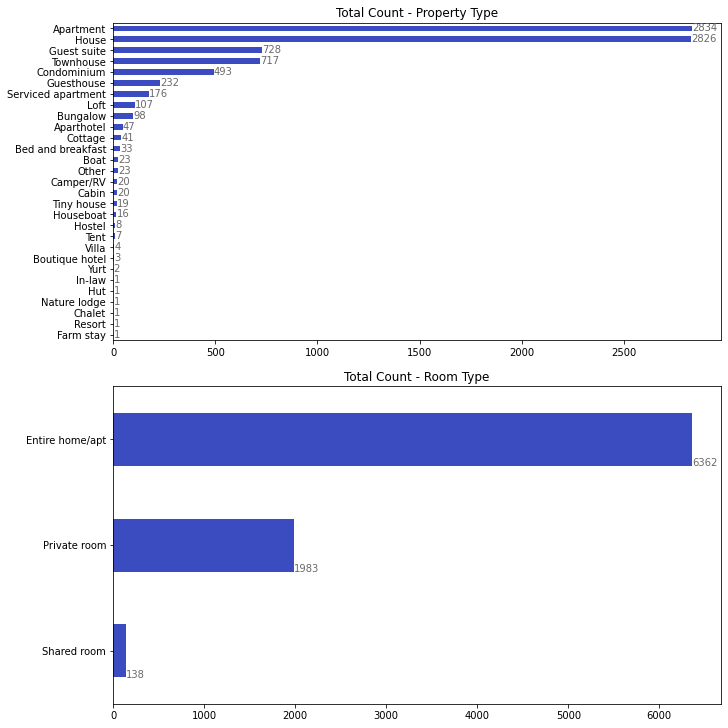

In [73]:
listings_neighbourhood = listings.copy(deep=True)


# Lets analyse the listing by different Property Type
def plot_value (col,x=10,y=2, ax=None, title=None):
    if ax:
        listings_neighbourhood[col].value_counts().sort_values().plot(kind = 'barh' , figsize = (x,y), ax=ax, title=title, cmap='coolwarm');
        for i in ax.patches:
            # get_width pulls left or right; get_y pushes up or down
            ax.text(i.get_width()+1, i.get_y(), \
                    f"{int(i.get_width())}", fontsize=10, color='dimgrey')
    else:
        listings_neighbourhood[col].value_counts().sort_values().plot(kind = 'barh' , figsize = (x,y), cmap='coolwarm');
        
def get_indexes_property_types(df, col): return df[col].value_counts().sort_values()[-10:].index.to_list()
    
    
    

# Set up the figure
fig = plt.figure(constrained_layout=True)

spec2 = gridspec.GridSpec(ncols=1, nrows=2, figure=fig)
ax1 = fig.add_subplot(spec2[0, 0])
ax2 = fig.add_subplot(spec2[1, 0])



plot_value ('room_type', y=3,ax=ax2, title="Total Count - Room Type")
plot_value ('property_type', y=10, ax=ax1, title="Total Count - Property Type")


In [74]:
# Selecting the ten most frequent property types
property_type_list = get_indexes_property_types(listings_neighbourhood, 'property_type')

# Filtering
filt = listings_neighbourhood['property_type'].isin(property_type_list)
listings_neighbourhood = listings_neighbourhood[filt]

# Prices Means Visualization

### Neighbourhoods Mean Prices:
- Higher 5 Mean Prices
- Lowest 5 Mean Prices

In [75]:
# Getting Mean Price by Neighbourhood
mean_price, median_price = mean_median_grouped_price(listings_neighbourhood, column_name='neighbourhood_cleansed')

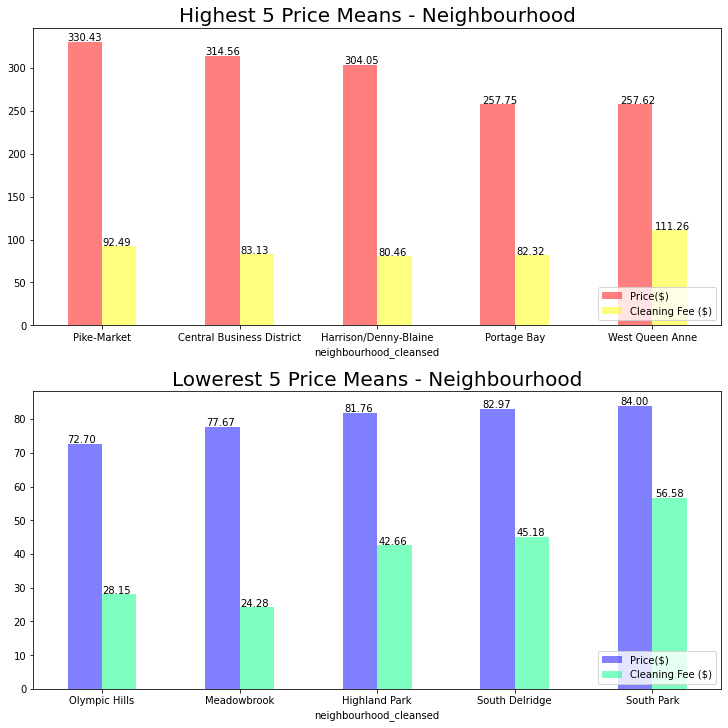

In [76]:
# Plotting Higher and Lower Mean Prices
plot_head_tail_prices(mean_price, m_type='mean', column_name='neighbourhood_cleansed');

In [77]:
# Mean and Median of Room Types without outliers (simple way)
room_mean_price, room_median_price = mean_median_grouped_price(listings_neighbourhood, column_name='room_type',outlier=True)

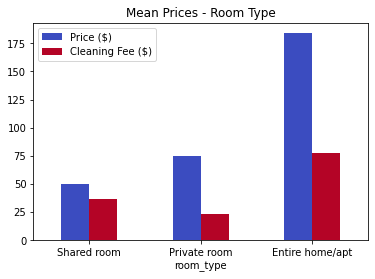

In [78]:
# Plot room_type mean price
room_mean_price.plot(kind = 'bar', title="Mean Prices - Room Type", cmap='coolwarm', rot=0).legend(['Price ($)', 'Cleaning Fee ($)']);

### Property Type Mean Prices

<ipython-input-79-be029341c2ae>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ax = df.groupby(df[col])['cleaning_fee','price'].mean().sort_values(by = 'price', ascending=False).plot(kind='bar', figsize = (15,10), cmap='coolwarm', alpha=0.6, rot=0);


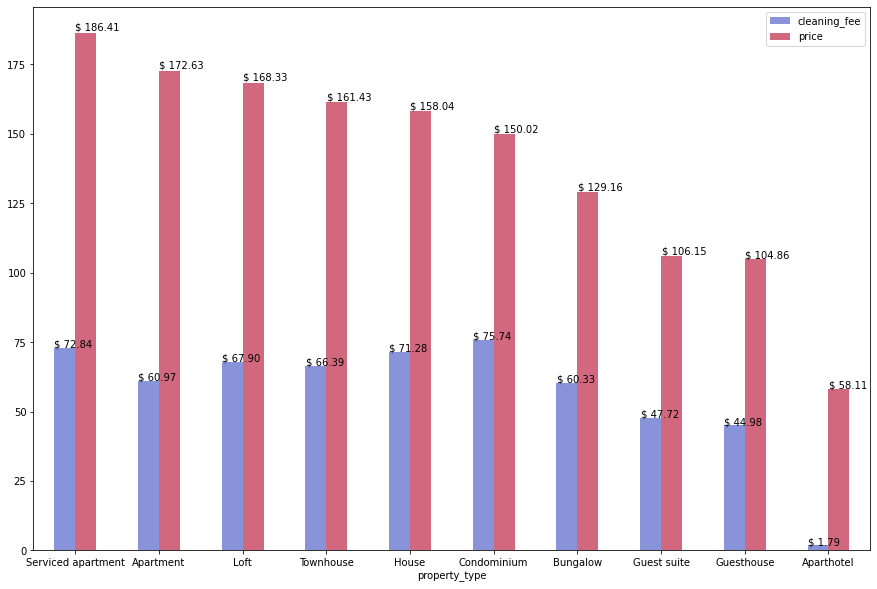

In [79]:
def plot_mean (col, df):
    ax = df.groupby(df[col])['cleaning_fee','price'].mean().sort_values(by = 'price', ascending=False).plot(kind='bar', figsize = (15,10), cmap='coolwarm', alpha=0.6, rot=0);
    for p in ax.patches:
            # get_x pulls left or right; get_height pushes up or down
            ax.annotate(f"$ {p.get_height():.2f}", (p.get_x() * 1.001, p.get_height() * 1.005), fontsize=10)
    fig = ax.get_figure()
    fig.savefig("property1.png")

# Ploting Property Types Means
plot_mean('property_type', listings_neighbourhood)

In [80]:
# Looking at maximum and minimum prices by property
df_prices = listings_neighbourhood.copy()
df_prices = df_prices.drop(df_prices[df_prices.price == 0].index)
df_prices['price_min'] = df_prices['price']

df_prices['price_max'] = df_prices['price']

prices_view = df_prices.groupby(df_prices['property_type'])['cleaning_fee','price', 'price_min', 'price_max'].agg({'price': 'mean', 'cleaning_fee':'mean', 'price_min':'min', 'price_max':'max'}).sort_values(by = 'price', ascending=False)

print(f"{'Property Type':^20} | {'Cleaning Fee Mean':^18} | {'Price_Mean':^10} | {'Price Min':^9} | {'Price Max':^9}")
print(f"{'-'*20:^20} | {'-'*18:^18} | {'-'*10:^10} | {'-'*9:^9} | {'-'*9:^9}")

for i, row in prices_view.iterrows():
    print(f"{i:^20} | {f'{round(row.cleaning_fee, 2)}':^18} | {round(row.price, 2):^10} | {row.price_min:^9} | {row.price_max:^9}")

   Property Type     | Cleaning Fee Mean  | Price_Mean | Price Min | Price Max
-------------------- | ------------------ | ---------- | --------- | ---------
 Serviced apartment  |       72.84        |   186.41   |   60.0    |   549.0  
     Apartment       |       60.96        |   172.75   |   10.0    |  1002.0  
        Loft         |        67.9        |   168.33   |   44.0    |   788.0  
     Townhouse       |       66.34        |   161.66   |   10.0    |  5400.0  
       House         |       71.28        |   158.04   |   10.0    |  4000.0  
    Condominium      |       75.74        |   150.02   |   30.0    |   550.0  
      Bungalow       |       60.33        |   129.16   |   10.0    |   450.0  
    Guest suite      |       47.74        |   106.29   |   10.0    |  1000.0  
     Guesthouse      |       44.98        |   104.86   |   30.0    |   300.0  
     Aparthotel      |        1.79        |   58.11    |   51.0    |   65.0   


<ipython-input-80-7125dcc33f56>:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  prices_view = df_prices.groupby(df_prices['property_type'])['cleaning_fee','price', 'price_min', 'price_max'].agg({'price': 'mean', 'cleaning_fee':'mean', 'price_min':'min', 'price_max':'max'}).sort_values(by = 'price', ascending=False)


### Cleaning Fee by Property Types

In [81]:
listings_neighbourhood_2 = listings_neighbourhood.drop(listings_neighbourhood[listings_neighbourhood.price == 0].index)

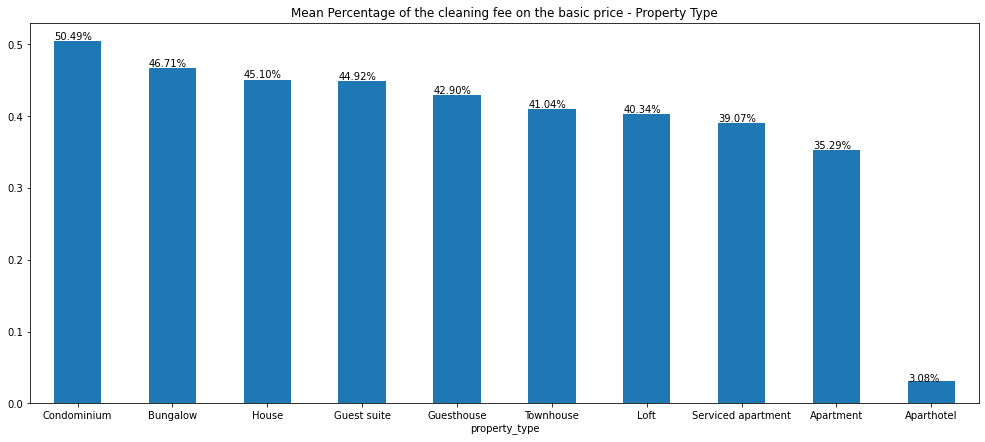

In [82]:
# Setting cleaning fee percentage over the price
#listings_neighbourhood_2['perc_cleaning_fee'] = listings_neighbourhood['cleaning_fee'] / listings_neighbourhood['price']

fee_perc_price = pd.DataFrame()
fee_perc_price['cleaning_fee'] = listings_neighbourhood_2.groupby(listings_neighbourhood_2['property_type'])['cleaning_fee'].mean()
fee_perc_price['price'] = listings_neighbourhood_2.groupby(listings_neighbourhood_2['property_type'])['price'].mean()
fee_perc_price['perc_cleaning_fee'] = fee_perc_price['cleaning_fee'] / fee_perc_price['price']


# Plotting - Percentage of the cleaning fee on the basic price
ax = fee_perc_price['perc_cleaning_fee'].sort_values(ascending=False).plot(kind = 'bar',rot=0,figsize = (17,7), title="Mean Percentage of the cleaning fee on the basic price - Property Type")
for p in ax.patches:
        # get_x pulls left or right; get_height pushes up or down
        ax.annotate(f"{p.get_height()*100:.2f}%", (p.get_x() * 1.001, p.get_height() * 1.005), fontsize=10)

In [83]:
# Show General "Cleaning Fee" Mean
print("General 'Cleaning Fee' Mean:")
print(f"{fee_perc_price['perc_cleaning_fee'].mean()*100:.2f}%")

General 'Cleaning Fee' Mean:
38.89%


# Prices by Season
#### Prices trend by the days

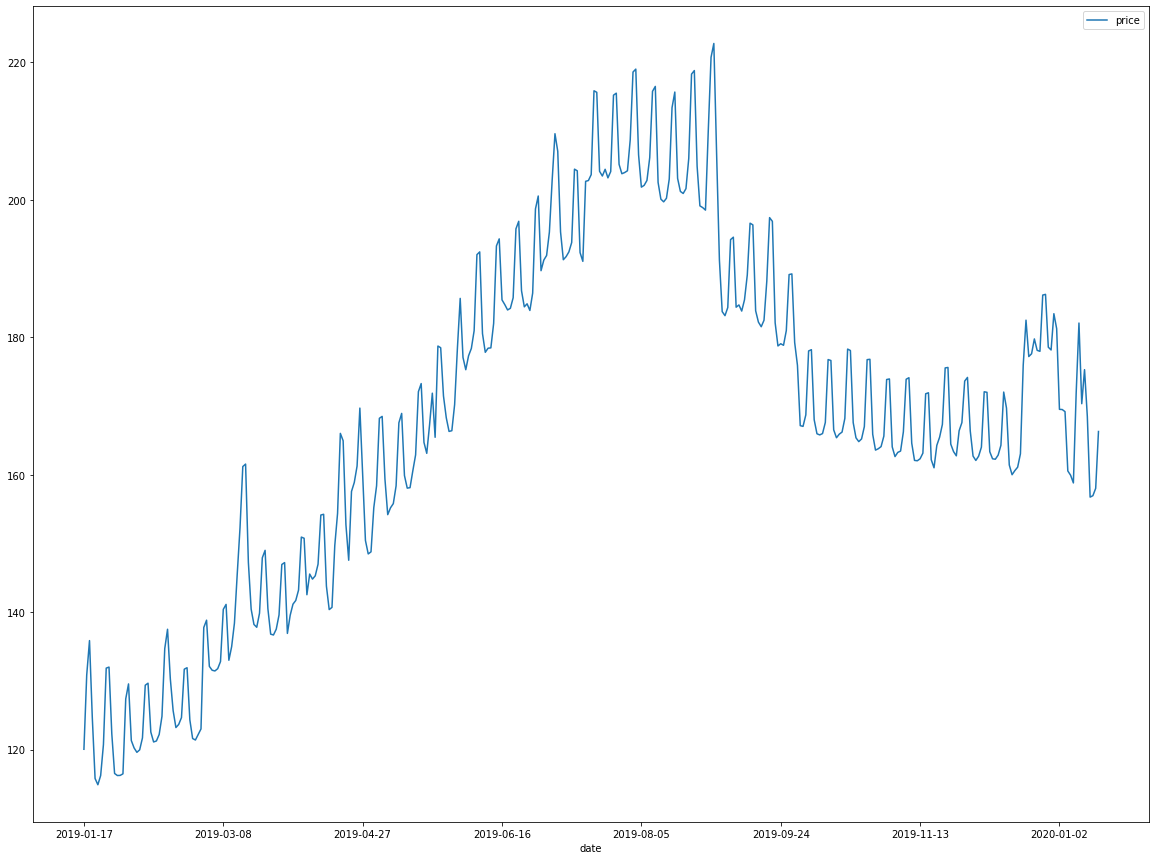

In [84]:
# group prices by date and take a mean to get around NaN values
day_price_mean = pd.DataFrame(calendar.query("available == True").groupby(['date']).mean()['price'])

day_price_mean.plot(kind = 'line',figsize = (20,15));

The chart above show the prices over time, but it is a bit confused yet. Let's see it grouped by month.



### Price Trend Grouped by Month

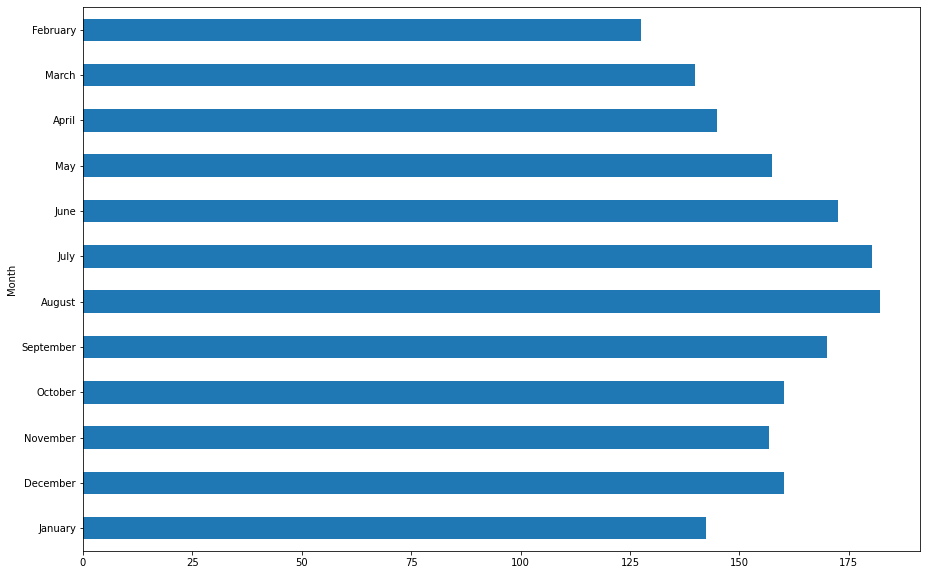

In [85]:
calendar['Month'] = pd.to_datetime(calendar['date'])
calendar = calendar.sort_values('Month', ascending=False)
month_mean = calendar.groupby(calendar['Month'].dt.strftime('%B'),
                                 sort=False)['price'].mean()

month = month_mean.plot(kind = 'barh' , figsize = (15,10));

The above chart shows: 

Higher prices
- June
- July
- August

Lower prices
- January
- February 
- March